In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'



In [2]:
model="materials"
dataset= "../nerf_synthetic/" + model
focal, all_c2w, all_gt = get_data(dataset, "test")

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.99it/s]


In [12]:
cust_c2ws = create_rotation_matrices(1.5, -20, n=60)
red_fac=2
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [7]:
class VoxelGrid_dev(VoxelGridSpherical):
    def smooth_colors(self):
        with torch.no_grad():
            new_ar = 6*self.colors.clone()
            opa_count = 6*(self.opacities!=0)
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] += self.colors[disp1:]*(self.opacities[disp1:]!=0)[..., None, None]
                opa_count[:-disp1] += (self.opacities!=0)[disp1:]
                new_ar[disp1:] += self.colors[:-disp1]*(self.opacities[:-disp1]!=0)[..., None, None]
                opa_count[disp1:] += (self.opacities!=0)[:-disp1]
            for disp1 in [1+self.size, 1-self.size, 1+self.size**2, 1-self.size**2, self.size+self.size**2, self.size-self.size**2]:
                new_ar[:-disp1] += 1/np.sqrt(2)*self.colors[disp1:]*(self.opacities[disp1:]!=0)[..., None, None]
                opa_count[:-disp1] += 1/np.sqrt(2)*(self.opacities!=0)[disp1:]
                new_ar[disp1:] += 1/np.sqrt(2)*self.colors[:-disp1]*(self.opacities[:-disp1]!=0)[..., None, None]
                opa_count[disp1:] += 1/np.sqrt(2)*(self.opacities!=0)[:-disp1]
            for disp1 in [1+self.size+self.size**2, 1-self.size+self.size**2, 1+self.size-self.size**2, 1-self.size-self.size**2]:
                new_ar[:-disp1] += 1/np.sqrt(3)*self.colors[disp1:]*(self.opacities[disp1:]!=0)[..., None, None]
                opa_count[:-disp1] += 1/np.sqrt(3)*(self.opacities!=0)[disp1:]
                new_ar[disp1:] += 1/np.sqrt(3)*self.colors[:-disp1]*(self.opacities[:-disp1]!=0)[..., None, None]
                opa_count[disp1:] += 1/np.sqrt(3)*(self.opacities!=0)[:-disp1]
            mask = opa_count!=0
            self.colors[mask] = new_ar[mask]/opa_count[mask, None, None]
    def smooth_opacities(self):
        with torch.no_grad():
            new_ar = 6*self.opacities.clone()
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] +=self.opacities[disp1:]
                new_ar[disp1:] += self.opacities[:-disp1]
            self.opacities[:] = new_ar/12
            
class VoxelGridSphericalCarve_dev(VoxelGridSphericalCarve):
    def view_harmonics(self, points):
        norm = torch.sqrt((points**2).sum(1))
        points /= norm[:, None]
        r2 = torch.sqrt((points[:, :2]**2).sum(1))
        r2 = normalize01(r2, 0, 1) #avoid numerical errors
        phi = np.pi/2-torch.arccos(r2)
        phi[points[:,2]<0] = np.pi-phi[points[:,2]<0] 
        r2[r2==0] = 10**-10 
        diam = points[:,0]/r2
        diam = normalize01(diam, -1, 1) #avoid numerical errors
        theta = torch.arccos(diam)
        theta[points[:,1]<0] *= -1  
        theta += np.pi
        theta = theta.cpu().numpy()
        phi = phi.cpu().numpy()
        harmonics = torch.zeros((points.shape[0], self.num_harm), device=device)
        ind=0
        for n in range(int(np.sqrt(self.num_harm))):
            for m in range(-n,n+1):
                Y = torch.tensor(sph_harm(abs(m),n,theta, phi), device=device)
                if m < 0:
                    Y = np.sqrt(2) * (-1)**m *  Y.imag
                elif m > 0:
                    Y = np.sqrt(2) * (-1)**m * Y.real
                else: 
                    Y = Y.real
                harmonics[:, ind] = Y
                ind+=1
        return harmonics
    def smooth_colors(self):
        with torch.no_grad():
            new_ar = 6*self.colors.clone()
            opa_count = 6*(self.opacities!=0)*1.0
            for disp1 in [1, self.size, self.size**2]:
                new_ar[:-disp1] += self.colors[disp1:]*(self.opacities[disp1:]!=0)[..., None, None]
                opa_count[:-disp1] += (self.opacities!=0)[disp1:]
                new_ar[disp1:] += self.colors[:-disp1]*(self.opacities[:-disp1]!=0)[..., None, None]
                opa_count[disp1:] += (self.opacities!=0)[:-disp1]
            for disp1 in [1+self.size, 1-self.size, 1+self.size**2, 1-self.size**2, self.size+self.size**2, self.size-self.size**2]:
                new_ar[:-disp1] += 1/np.sqrt(2)*self.colors[disp1:]*(self.opacities[disp1:]!=0)[..., None, None]
                opa_count[:-disp1] += 1/np.sqrt(2)*(self.opacities!=0)[disp1:]
                new_ar[disp1:] += 1/np.sqrt(2)*self.colors[:-disp1]*(self.opacities[:-disp1]!=0)[..., None, None]
                opa_count[disp1:] += 1/np.sqrt(2)*(self.opacities!=0)[:-disp1]
            for disp1 in [1+self.size+self.size**2, 1-self.size+self.size**2, 1+self.size-self.size**2, 1-self.size-self.size**2]:
                new_ar[:-disp1] += 1/np.sqrt(3)*self.colors[disp1:]*(self.opacities[disp1:]!=0)[..., None, None]
                opa_count[:-disp1] += 1/np.sqrt(3)*(self.opacities!=0)[disp1:]
                new_ar[disp1:] += 1/np.sqrt(3)*self.colors[:-disp1]*(self.opacities[:-disp1]!=0)[..., None, None]
                opa_count[disp1:] += 1/np.sqrt(3)*(self.opacities!=0)[:-disp1]
            mask = opa_count!=0
            self.colors[mask] = new_ar[mask]/opa_count[mask, None, None]

    

In [8]:
1/np.sqrt(2.0)

0.7071067811865475

In [9]:
VG=VoxelGridSphericalCarve_dev(128, 1.4, 40, 9)

#VG=VoxelGrid()
#VG.load(model+'.obj')


#VG.load("../saved_grids_carve/materials.obj")


VG.load('materials_sph.obj')
#VG.save_pointcloud()



In [19]:
VG.opacities.max()

tensor(40., device='cuda:0', grad_fn=<MaxBackward1>)

  0%|                                                    | 0/60 [00:00<?, ?it/s]

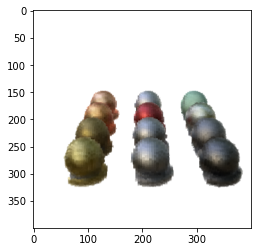

  2%|▋                                           | 1/60 [00:01<01:08,  1.16s/it]

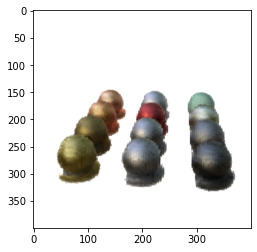

  3%|█▍                                          | 2/60 [00:03<01:27,  1.52s/it]


KeyboardInterrupt: 

In [13]:
imgs=[]
for image_ind in tqdm(range(len(cust_c2ws))):
    with torch.no_grad():
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind],(900, 1.2))
        plt.imshow(new_im)
        plt.show()
        imgs.append(np.uint8(255*new_im))

In [44]:
imageio.mimwrite('exports/materials_sph3.gif', imgs,  format='GIF', duration=0.04)

In [7]:
plt.imsave('exports/carve/lego.png', imgs[1])

# PSNR

In [16]:
test_focal, test_c2w, test_gt = get_data("../nerf_synthetic/" + model, "test")

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.05it/s]


In [17]:
red = 8
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims_test[0].shape[0]

In [20]:
print(compute_psnr(VG, disp_rays_test, disp_ims_test, 900))

100%|█████████████████████████████████████████| 200/200 [00:17<00:00, 11.21it/s]

22.50236548088684


In [14]:
VG.save('materials')

128

In [72]:
VG.smooth_colors()

13


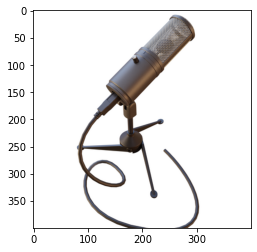

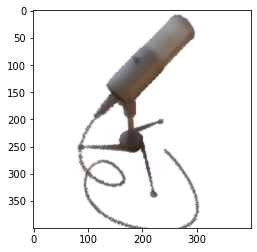

In [77]:
image_ind=np.random.randint(99)
print(image_ind)
im_ref = disp_ims_test[image_ind]
new_im = VG.render_large_image_from_rays(disp_rays_test[image_ind],(900,1.2), 500)
plt.imshow(im_ref)
plt.show()
plt.imshow(new_im)
plt.show()

In [16]:
VG2 = VoxelGridSpherical(10,1.2,9)
self = VG2

# Harmonics

In [ ]:
cust_c2ws = create_rotation_matrices(1.5, -20, n=60)
red_fac=2
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [17]:
VG2 = VoxelGridSphericalCarve_dev(128, 1.4, 40, 9)
for harm_ind in tqdm(range(9)):
    #harm_ind=2
    VG2=VoxelGridCarve(128,1)
    m = torch.arange(VG.size**3, device=device)

    x = m%VG2.size - VG2.size/2+0.01
    vm1 = torch.div(m, VG.size, rounding_mode='floor')
    y = vm1%VG2.size - VG2.size/2+0.001
    z = torch.div(vm1, VG2.size, rounding_mode='floor')%VG2.size - VG2.size/2+0.001
    points = torch.cat((x[:, None],y[:, None],z[:, None]),1)
    radius = (points**2).sum(1)
    with torch.no_grad():
        VG2.opacities[:] = 100
        VG2.colors[:] = 0
        VG2.opacities[torch.sqrt(radius)>VG.size/2] = 0

        harmonics = VG.view_harmonics(points)
        v = harmonics[:, harm_ind]/harmonics[:, harm_ind].max()
        VG2.colors[:, 0] = 0.5-v
        VG2.colors[:, 2] = 0.5+v
        #VG.colors[:, 1:] = view_harmonics(self, points)[..., None]/2/np.pi
        
    im = VG2.render_large_image_from_rays(ordir_rays[7],(200, 1.2))
    plt.imshow(im)
    plt.show()
    plt.imsave('exports/spherical_harmonics/harmonics_'+str(harm_ind)+'.png', im)
    #ims = []
    #for image_ind in (range(len(cust_c2ws))):
        #with torch.no_grad():
           # ims.append(VG.render_large_image_from_rays(ordir_rays[image_ind],(200, 1.2)))
   # imageio.mimwrite('exports/spherical_harmonics/'+str(harm_ind)+'.gif', ims,  format='GIF', duration=0.04)